## [NYCDSA Capstone Project] 
# Women's Softball League Power Ranking Estimate

<br>
Koeun Lim (koeunlim@alum.mit.edu)<br>
Kevin Haghi (kevin.haghi@gmail.com)<br>


# Step 8. Visualization & Dashboard

---
## Project Description



### Project Outline
- Step 1. Web scraping
- Step 2. Clean data
- Step 3. EDA
- Step 4. Imputation & PCA
- Step 5. Modeling (1) RPI prediction based on stats - Linear regression
- Step 6. Modeling (2) WS 64 Seed prediction based on stats - Logistic regression
- Step 7. Modeling (3) WS Ranking prediction based on stats - Multi-class Logistic regression
- Step 8. Visualization & Dashboard

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

from jupyter_dash import JupyterDash
import dash_bootstrap_components as dbc

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 5)
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)

In [2]:
# When running in JupyterHub or Binder, call the infer_jupyter_config function to detect the proxy configuration.
#JupyterDash.infer_jupyter_proxy_config()

### Load data & Preprocess

In [32]:
### Load current stats
df_all = pd.read_csv('Data/Clean_final.csv')
df_2019 = df_all[df_all.Year == 2019]
df_2019['Hit_Batters'] = -df_2019['Hit_Batters']
df_2019['Earned_Run_Average'] = -df_2019['Earned_Run_Average']

###############################
#Reorder to display as desired#
###############################
to_reorder = df_2019.columns.tolist()
to_reorder = [to_reorder[11], to_reorder[10], to_reorder[21], to_reorder[16], to_reorder[18], \
 to_reorder[22], to_reorder[14], to_reorder[15], to_reorder[19], to_reorder[13], to_reorder[20], \
 to_reorder[23], to_reorder[17], to_reorder[12], to_reorder[9]]    

df_2019_ord = df_2019[to_reorder]


scaler = StandardScaler()
df_2019_norm = pd.concat([df_2019.College,\
                          pd.DataFrame(scaler.fit_transform(df_2019_ord))],axis=1)
df_2019_norm.columns = ['College'] + list(df_2019_ord.columns)

df_norm = pd.DataFrame(scaler.fit_transform(df_2019_ord))
#df_norm.columns = df_2019.columns[9:24]
df_norm = pd.DataFrame(df_norm.stack()).reset_index().drop(columns=['level_0'])
df_norm.columns = ['Stats','Score']

indicator_college = np.sort(df_2019.College.unique())

### Load RPI prediction
df_RPI = pd.read_csv('RPI/RPI_prediction_logit_1000.csv')

### Load WS 64 Seeds prediction
df_WS64 = pd.read_csv('WS64Seeds/WS64_prediction_SGDlogistic_1000_famd_ext2.csv')

### Load WS Ranking prediction
df_WSProb = pd.read_csv('WSRank/WSProb_prediction_logistic_1000_famd.csv')
df_WSRank = pd.read_csv('WSRank/WSRank_prediction_logistic_1000_famd.csv')

<ipython-input-32-48f7d8954669>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-32-48f7d8954669>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [71]:
stats_list = df_norm.Stats.unique()
N = len(df_norm.Stats.unique())
c = ['#f2d14b','#997a8d','#a978ad','#d183b5','#d89bbc','#f4cdcc','#e99b9a','#dc6c64','#dda982','#2a4d69','#638ec1','#6c94cc','#63ace5','#55b3d0','#80c5d0']
#c = ['hsl('+str(h)+',72%'+',72%)' for h in np.linspace(0, 360, N)]

In [41]:
def get_250(df_sorted,rpi_predict):
    idx_rpi = df_sorted.index[df_sorted['index'] == rpi_predict][0]
    df_sorted.iloc[idx_rpi,1] = df_sorted.iloc[idx_rpi,1]/2
    
    n_sum_upper = 0
    i_upper = 1
    while n_sum_upper < 250:
        n_sum_upper = df_sorted.iloc[idx_rpi:idx_rpi+i_upper,1].sum()        
        i_upper += 1
        
        if (idx_rpi+i_upper) > len(df_sorted):
            n_sum_upper = 250
        print(n_sum_upper)
    
    n_sum_lower = 0
    i_lower = 0
    while n_sum_lower < 250:
        n_sum_lower = df_sorted.iloc[idx_rpi-i_lower:idx_rpi+1,1].sum()        
        i_lower += 1
        
        if (idx_rpi-i_lower) <= 0:
            n_sum_lower = 250
        print(n_sum_lower)
    
    print(idx_rpi+i_upper)
    print(idx_rpi-i_lower)
    return df_sorted['index'][idx_rpi+i_upper-2], df_sorted['index'][idx_rpi-i_lower+1]

### Construct the App

In [73]:
app = JupyterDash(__name__, external_stylesheets=[dbc.themes.MINTY])

### Navbar components
SB_LOGO = "https://www.ncaa.com/modules/custom/casablanca_core/img/sportbanners/softball.png"

navbar = dbc.Navbar(
    [
        html.A(
            # Use row and col to control vertical alignment of logo
            dbc.Row(
                [
                    dbc.Col(html.Img(src=SB_LOGO, height="30px")),
                    dbc.Col(dbc.NavbarBrand("Women's College Softball Projections", className="ml-2")),
                ],
                align="center",
                no_gutters=True,
            ),
        ),
        dbc.NavbarToggler(id="navbar-toggler"),
        dbc.Collapse(
                dbc.Nav(
                    [
                        dbc.DropdownMenu(
                            [
                                dbc.DropdownMenuItem("Data", header=True),
                                dbc.DropdownMenuItem("Download"),
                                dbc.DropdownMenuItem(divider=True),
                                dbc.DropdownMenuItem("External Links", header=True),
                                dbc.DropdownMenuItem("NCAA",href="https://www.ncaa.com/sports/softball/d1"),
                                dbc.DropdownMenuItem("World Series",href="https://www.ncaa.com/news/softball/article/2020-05-04/womens-college-world-series-2021-schedule"),
                            ],
                            nav=True,
                            in_navbar=True,
                            label="More",
                        ),
                    ],
                    className="ml-auto", 
                    navbar=True,
                ),
                id="navbar-collapse",
                navbar=True,
            ),
    ],
    color="dark",
    dark=True,
    className="mb-5",
    style={"margin-bottom":0},
)

#Can define a historical card here
#Make cards with little bits of info instead of all in one


### Sidebar components
SIDEBAR_STYLE = {
    "padding": "1rem 1rem 30rem",
    "background-color": '#e4f5f2',
}


sidebar = html.Div(
    [
        html.H6("Team Stats", id='college_out'), #Header
        html.Hr(), #Line
        dcc.Dropdown(
            id='college-dropdown',
            options=[{'label': i, 'value': i} for i in indicator_college],
            placeholder = 'Select a college'
        ),
        html.Br(), #Break 
        
        #Insert different cards here
    ],
    style=SIDEBAR_STYLE,
)

### Main content components
CONTENT_STYLE = {
    "padding": "1rem 1rem",
}

# Content 1: Current stats summary
fig1 = go.Figure(data=[go.Box(
    y=df_2019_norm.iloc[:,i+1],marker_color=c[i],boxpoints=False,
    name=df_2019_norm.columns[i+1].replace('_',' ')) for i in range(int(N))])
fig1.update_layout(
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(zeroline=True, gridcolor='white',
               tickmode='array',tickvals=[-3, -1.64, 0, 1.64, 3],ticktext=['Worse  ','(Bottom 5%)', 'Average', '(Top 5%)', 'Better  ']),
    paper_bgcolor="#f7f7f9",
    plot_bgcolor='#f7f7f9',#yaxis_title='Relative Score',
    height=400,
    yaxis_range=[-6,6],
    margin=dict(
        l=80,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
)

tab1_content = dbc.Card(
    dbc.CardBody(
        [
            html.H5("Current Stats Summary: All Teams",id='stats_description',className="card-title"),
            dcc.Graph(id='current_stats',figure=fig1)
        ],
        id='tab1_stats',
        style=CONTENT_STYLE,
    ),
    className="mt-3",
)
# Content 2: RPI Projection
tab2_content = dbc.Card(
    dbc.CardBody(
        [
            html.H5("RPI Projection: Select a Team",id='RPI_description'),
            dcc.Graph(id='RPI_projection'),
            html.P(id='RPI_range'),  #P-text entry
        ],
        id='tsb2_RPI',
        style=CONTENT_STYLE,
    ),
    className="mt-3",
)

# Content 3: WS Projection
tab3_content = dbc.Card([
    dbc.CardBody(
        [
            html.H5("WS Projection: Select a Team",id='WS_description',className="card-title"),
            dbc.Card(
                [
                    dbc.CardHeader("NCWA Tournament"),
                    dbc.CardBody(
                        dcc.Graph(id='WS_projection'),
                    ),
                    dbc.CardFooter(
                        [
                            html.P(id='WS_seed_prob',className="card-text"),
                            html.P(id='WS_seed_odds',className="card-text"),
                        ]
                    ),
                ],color="secondary", outline=True,className="w-90 mb-3 mt-3 ml-3",
            ),
        ],
        id='tab3_WS',
        style=CONTENT_STYLE,
    ),
    ], color="light", outline=True,
    className="mt-3",
)

tabs = dbc.Tabs(
    [
        dbc.Tab(tab1_content, label="Current Stats"),
        dbc.Tab(tab2_content, label="RPI Projection"),
        dbc.Tab(tab3_content, label="NCAA Tournament Projection"),
    ]
)



### Construct app =============================================
app.layout = html.Div([
    dbc.Row(dbc.Col(navbar)),
    dbc.Row(
        [
            dbc.Col(sidebar,width=3),
            dbc.Col(tabs),
        ],
        no_gutters=False,
    )
])


# Navbar toggler
@app.callback(
    Output("navbar-collapse", "is_open"),
    [Input("navbar-toggler", "n_clicks")],
    [State("navbar-collapse", "is_open")],
)
def toggle_navbar_collapse(n, is_open):
    if n:
        return not is_open
    return is_open


# Stats Summary
@app.callback(
    Output('stats_description','children'),
    Output("current_stats", "figure"),
    Output('RPI_description','children'),
    Output('RPI_projection','figure'),
    Output('RPI_range','children'),
    Output('WS_description','children'),
    Output('WS_seed_prob','children'),
    Output('WS_seed_odds','children'),
    Output('WS_projection','figure'),   #output('','kind, e.g. children, figure')
    [Input('college-dropdown', 'value')],
)
def update_content(college):
    if not college:
        #Need to define how to update the sidebar cards based on no college selected
        
        text1 = "Current Stats Summary: All Teams"
        fig1 = go.Figure(data=[go.Box(
            y=df_2019_norm.iloc[:,i+1],marker_color=c[i],boxpoints=False,
            name=df_2019_norm.columns[i+1].replace('_',' ')) for i in range(int(N))])
        fig1.update_layout(
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(zeroline=True, gridcolor='white',
                       tickmode='array',tickvals=[-3, -1.64, 0, 1.64, 3],ticktext=['Worse  ','(Bottom 5%)', 'Average', '(Top 5%)', 'Better  ']),
            paper_bgcolor="#f7f7f9",
            plot_bgcolor='#f7f7f9',#yaxis_title='Relative Score',
            height=400,
            yaxis_range=[-6,6],
            margin=dict(
                l=80,
                r=50,
                b=50,
                t=50,
                pad=4
            ),
        )
        
        text2 = "RPI Projection: Select a Team"
        text2_1 = ' '
        
        text3_1 = "NCAA Tournament Projection: Select a Team"
        
        text3_2 = " "
        
        text3_3 = " "
        
        
        return text1, fig1, text2, fig1, text2_1, text3_1, text3_2, text3_3, fig1
    else:
        #Need to define how to update the sidebar cards based on college selection
        
        
        # Content 1
        text1 = "Current Stats Summary: {}".format(college)
        filtered_df = df_2019_norm[df_2019_norm.College == college].iloc[:,1:16]
        fig1 = go.Figure(
            data=[go.Bar(y=filtered_df.iloc[:,i],marker_color=c[i],name=filtered_df.columns[i].replace('_',' ')) for i in range(int(N))])
    
        fig1.update_layout(
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(zeroline=True, gridcolor='white',
                       tickmode='array',tickvals=[-3, -1.64, 0, 1.64, 3],ticktext=['Worse  ','(Bottom 5%)', 'Average', '(Top 5%)', 'Better  ']),
            paper_bgcolor="#f7f7f9",
            plot_bgcolor='#f7f7f9',#yaxis_title='Relative Score',
            height=400,
            yaxis_range=[-5,5],
            margin=dict(
                l=80,
                r=50,
                b=50,
                t=50,
                pad=4
            ),
        )
        
        # Content 2
        bins_fig2 = int(np.max(df_RPI[college]) - np.min(df_RPI[college]))
        if bins_fig2 == 0:
            bins_fig2 = 1
        text2 = 'Predicted RPI rank for {}: {}'.format(college, df_RPI[college].value_counts().idxmax())
        fig2 = px.histogram(df_RPI,x=college,marginal="violin",nbins=bins_fig2) 
        
        RPI_predict = df_RPI[college].value_counts().idxmax()
        RPI_sorted = df_RPI[college].value_counts().sort_index(ascending=False).reset_index()
        RPI_bounds = get_250(RPI_sorted,RPI_predict)
        
        text2_1 = 'Range of RPI ranking predictions: [{},{}]'.format(RPI_bounds[0],RPI_bounds[1])
        
        #plt.title(college + ' RPI Ranking')
        #plt.ylabel('Tenth Percent')
        #plt.xlim(1,np.round(df_y_rank[college].max()/10)*10)
        
        # Content 3
        text3_1 = 'NCAA Tournament Projection: {}'.format(college)
        
        bins_fig3_1 = len(np.linspace(0,1,20))
        fig3_1 = px.histogram(df_WS64,x=college,marginal='violin') 
        
        mode_WS_prob = df_WS64[college].value_counts().idxmax()
        odds_WS = np.round(mode_WS_prob/(1-mode_WS_prob),decimals=2)
        
        text3_2 = 'Predicted result (% peak chance making into WS): {}'.format(mode_WS_prob*100)
        text3_3 = 'Odds making into NCAA Tournament (100 max, >1 indicates greater odds making): {}'.format(odds_WS)
        #plt.title(college + ' WS Seeding % Chance')
        #plt.ylabel('Tenth Percent')
        #plt.show()
        #print('Actual result: ', y_WSin_2019.WCWS_in.loc[idx_ex])
        #print('Average percent chance making into WS (%):', np.round(df_WSin_meanProb[college][0]*100))
        #print('Odds making into WS (100 max, >1 indicates greater odds making): ', np.round(df_WSin_odds[college][0],decimals=2))
        #print('Predicted result (% peak chance making into WS): ',df_prob_in_5[college].value_counts().idxmax())
        
        return text1, fig1, text2, fig2, text2_1, text3_1, text3_2, text3_3, fig3_1
#---

# Run the app
if __name__ == '__main__':
    app.run_server(mode='inline',port=8080,debug=True)
    #app.run_server(mode='inline',port=8080,debug=True)
    

208.0
415.0
208.0
498.0
7
2


<ipython-input-73-3552c67a150f>:278: RuntimeWarning:

divide by zero encountered in double_scalars



250
470.0
7
4


<ipython-input-73-3552c67a150f>:278: RuntimeWarning:

divide by zero encountered in double_scalars



,Fielding_Percentage,Scoring,WL_Percentage,Hit_Batters,Earned_Run_Average,Triples_per_Game,Home_Runs_per_game,Slugging_Percentage,Double_Plays_per_Game,On_Base_Percentage,Stolen_Bases_per_Game,Strikeout-to-Walk_Ratio,Batting_Average,Doubles_per_Game
1,1.435825,2.59314,2.43378,1.096129,-1.774526,0.602302,1.858998,2.218909,-0.577269,2.117728,0.038297,4.090553,2.489784,0.983915


<AxesSubplot:xlabel='Stats', ylabel='Score'>

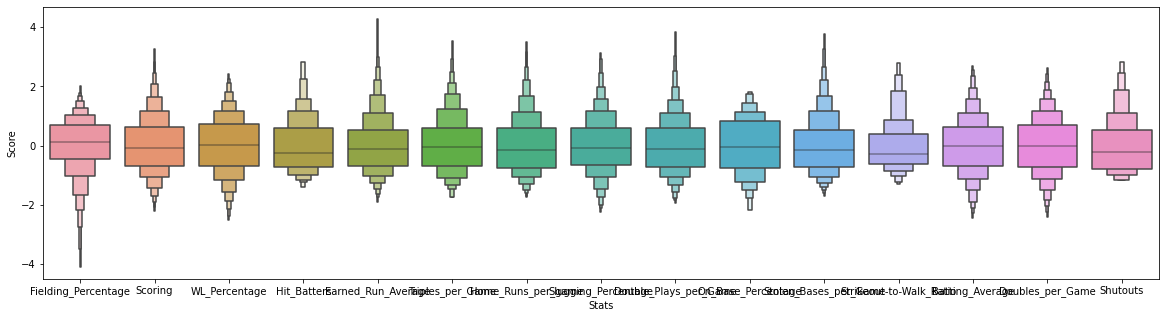

In [47]:
sns.boxenplot(data=df_norm,x='Stats',y='Score',showfliers=False)

In [124]:
def get_250(df_sorted,rpi_predict):
    idx_rpi = df_sorted.index[df_sorted['index'] == rpi_predict][0]
    
    n_sum_upper = 0
    i_upper = 1
    while n_sum_upper < 250:
        n_sum_upper = df_sorted.iloc[idx_rpi:idx_rpi+i_upper,1].sum()        
        i_upper += 1
        
        if (idx_rpi+i_upper) > len(df_sorted):
            n_sum_upper = 250
        print(n_sum_upper)
    
    n_sum_lower = 0
    i_lower = 0
    while n_sum_lower < 250:
        n_sum_lower = df_sorted.iloc[idx_rpi-i_lower:idx_rpi+1,1].sum()        
        i_lower += 1
        
        if (idx_rpi-i_lower) <= 0:
            n_sum_lower = 250
        print(n_sum_lower)
    
    print(idx_rpi+i_upper-1)
    print(idx_rpi-i_lower+1)
    return df_sorted['index'][idx_rpi+i_upper-2], df_sorted['index'][idx_rpi-i_lower+1]

RPI_predict = df_RPI['UCLA'].value_counts().idxmax()
RPI_sorted = df_RPI['UCLA'].value_counts().sort_index(ascending=False).reset_index()
RPI_bounds = get_250(RPI_sorted,RPI_predict)
RPI_bounds[0]

250
940
6
5


2.0

In [115]:
idx_RPI = RPI_sorted.index[RPI_sorted['index'] == RPI_predict][0]
print(RPI_sorted.iloc[idx_RPI,1])
RPI_sorted.iloc[idx_RPI,1] = RPI_sorted.iloc[idx_RPI,1]/2
print(RPI_sorted.iloc[idx_RPI,1])

433
216.5


In [125]:
RPI_sorted

,index,UCLA
0,7.0,1
1,6.0,1
2,5.0,1
3,4.0,7
4,3.0,50
5,2.0,940
